# Urban Observatory Sensor Quick Stats

In [4]:
#%matplotlib inline

# imports
import pandas as pd
from pandas.tseries.offsets import *
import glob

import datetime
from datetime import timedelta

from matplotlib import pyplot as plt

# missing data
import missingno as msno

## Read in the data file
Get data from Urban Observatory __[download](http://uoweb1.ncl.ac.uk/download/)__ website

In [5]:
# working folder
folder = 'baseline/'

# data file
source = folder + 'data.csv'

# sensor description file (Epoch is sampling frequency)
# Sensor Name | Location Name | Location (WKT) | Ground Height Above Sea Level | Sensor Height Above Ground | Broker Name | Third Party | Sensor Centroid Longitude Sensor Centroid Latitude | DeploymentStart | DeploymentEnd | Epoch
# PER_AIRMON_MESH1971150 | Coast Road Corner House | POINT (-1.58378809690475 54.9911393751596) | 45.54999924 | 2 | Air Monitors | FALSE | -1.583788097 | 54.99113938 | 25/06/2018 | | 900
sensors = folder + 'sensors.csv'

rawdata=pd.read_csv(source,sep=',',index_col=False, header=0)
rawdata = rawdata.drop_duplicates()
#rawdata = rawdata[rawdata['Variable'] == 'NO2' ]
sensordata = pd.read_csv(sensors,sep=',',index_col=False, header=0)
#sensordata = pd.concat([pd.read_csv(f) for f in glob.glob(sensors)], ignore_index = True)

# get deplyment times and fill in current time if end missing
sensordata['DeploymentEnd'].fillna(datetime.datetime.now().date(),inplace=True)
sensordata['DeploymentStart'] = pd.to_datetime(sensordata['DeploymentStart'])
sensordata['DeploymentEnd'] = pd.to_datetime(sensordata['DeploymentEnd'])

# convert to datetime
rawdata['Timestamp'] = pd.to_datetime(rawdata['Timestamp'])
rawdata = rawdata.set_index('Timestamp')
#includes times that doesn't exit
#rawdata = rawdata.tz_localize('utc').reset_index()
sensordata

,Sensor Name,Location Name,Location (WKT),Ground Height Above Sea Level,Sensor Height Above Ground,Broker Name,Third Party,Sensor Centroid Longitude,Sensor Centroid Latitude,DeploymentStart,DeploymentEnd,Epoch
0,PER_AIRMON_MESH1971150,Coast Road Corner House,POINT (-1.58378809690475 54.9911393751596),45.549999,2,Air Monitors,False,-1.583788,54.991139,2018-06-25,2019-02-26,900
1,PER_AIRMON_MESH1904150,Cragside Primary School,POINT (-1.576274 54.984381),42.520000,2,Air Monitors,False,-1.576274,54.984381,2018-10-15,2019-02-26,900
2,PER_AIRMON_MESH1970150,Chillingham Rd Primary,POINT (-1.5762135386467 54.9843088529622),42.270000,2,Air Monitors,False,-1.576214,54.984309,2018-06-25,2018-09-06,900
3,PER_AIRMON_MESH1970150,Chillingham Rd Primary,POINT (-1.5762135386467 54.9843088529622),42.270000,2,Air Monitors,False,-1.576214,54.984309,2018-10-08,2019-02-26,900
4,PER_AIRMON_MESH1905150,St Teresa's Primary School,POINT (-1.583685 54.991163),45.869999,2,Air Monitors,False,-1.583685,54.991163,2018-08-06,2018-09-06,900
5,PER_AIRMON_MESH1905150,St Teresa's Primary School,POINT (-1.583685 54.991163),45.869999,2,Air Monitors,False,-1.583685,54.991163,2018-10-08,2019-02-26,900
6,PER_AIRMON_MESH1911150,Cartington Terrace,POINT (-1.577888 54.98891),48.410000,2,Air Monitors,False,-1.577888,54.988910,2018-06-25,2018-10-03,900
7,PER_AIRMON_MESH1909150,Warwick Street,POINT (-1.666337254326701 55.01368669822206),NaN,2,Air Monitors,False,-1.666337,55.013687,2018-06-25,2018-09-11,900


## Visualise Sensor Locations

Lowered zoom level to keep map size reasonable. (z = 13)


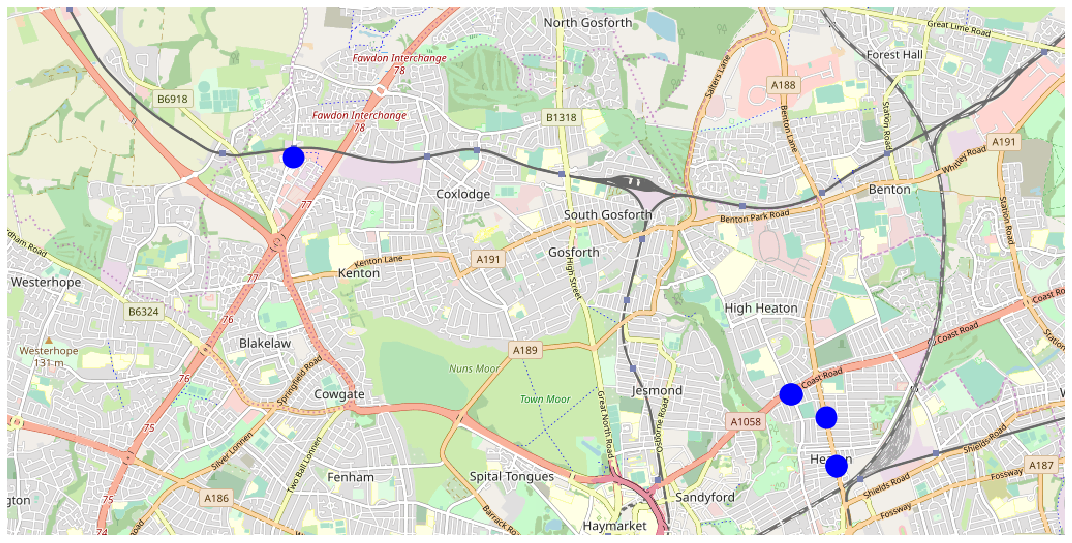

In [6]:
import smopy
import matplotlib.patheffects as pe

bbox = (
    min(sensordata['Sensor Centroid Latitude']),
    min(sensordata['Sensor Centroid Longitude']),
    max(sensordata['Sensor Centroid Latitude']),
    max(sensordata['Sensor Centroid Longitude']),
)

map = smopy.Map(bbox, z=17)
ax = map.show_mpl(figsize=(15, 15))
for i,row in sensordata.iterrows():
    x, y = map.to_pixels(row['Sensor Centroid Latitude'], row['Sensor Centroid Longitude'])
    ax.plot(x, y, 'ob', ms=20, mew=2);
    

## TODO: Filter out deployment times

## Data Quality assessment

In [8]:
# remove data that is outside the deployment times (in case sensor had been taken to GOLD_NODE turing the deployment)
cleandata = pd.DataFrame()
for index, row in sensordata.iterrows():
    mask = (((rawdata.index >= row['DeploymentStart']) & (rawdata.index <= row['DeploymentEnd'])))
    sensor_set = rawdata.loc[(rawdata['Sensor Name'] == row['Sensor Name']) & (mask)]
    cleandata = cleandata.append(sensor_set)

cleandata = cleandata.reset_index()
cleandata.head()

,Timestamp,Sensor Name,Variable,Units,Value,Flagged as Suspect Reading
0,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,Particle Count,Kgm -3,5.855000,False
1,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,PM1,ugm -3,0.791400,False
2,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,PM10,ugm -3,5.314220,False
3,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,PM2.5,ugm -3,1.390732,False
4,2018-06-25 00:02:00,PER_AIRMON_MESH1971150,Particle Count,Kgm -3,2.751000,False


### Number of Flagged as Suspect Readings

In [9]:
data = cleandata.copy()

# number of flagged readings
flagged = data[data['Flagged as Suspect Reading'] == True].groupby(['Sensor Name',  'Variable'])['Flagged as Suspect Reading'].value_counts()
flagged.to_csv(folder+'flagged_as_suspect_reading.csv', encoding='utf-8',header=True)
flagged

Sensor Name             Variable  Flagged as Suspect Reading
PER_AIRMON_MESH1904150  NO        True                           721
PER_AIRMON_MESH1905150  NO        True                          2060
PER_AIRMON_MESH1911150  NO        True                           347
                        NO2       True                             3
PER_AIRMON_MESH1970150  NO        True                          2039
Name: Flagged as Suspect Reading, dtype: int64

### Min and Max 
For each sensor

In [10]:
# min max datetimes for all sensors in the list
data = cleandata.copy()
data = pd.pivot_table(cleandata, values = 'Value', index=['Sensor Name','Timestamp'], columns = 'Variable').reset_index()
minmax = data.groupby('Sensor Name')['Timestamp'].agg(['min','max']).reset_index()
minmax.to_csv(folder+'min_max.csv', encoding='utf-8',header=True,index=False)
minmax

,Sensor Name,min,max
0,PER_AIRMON_MESH1904150,2018-10-15 00:00:00,2018-11-14 23:00:00
1,PER_AIRMON_MESH1905150,2018-08-06 00:00:00,2018-11-14 23:00:00
2,PER_AIRMON_MESH1909150,2018-06-25 00:15:00,2018-09-11 00:00:00
3,PER_AIRMON_MESH1911150,2018-06-25 00:15:00,2018-10-03 00:00:00
4,PER_AIRMON_MESH1970150,2018-06-25 00:15:00,2018-11-14 23:00:00
5,PER_AIRMON_MESH1971150,2018-06-25 00:01:00,2018-11-14 23:04:00


### Missing Data

If sensors get relocated the missing data gets messed up

Error processing PER_AIRMON_MESH1971150
'Could not divide time index into desired frequency.'


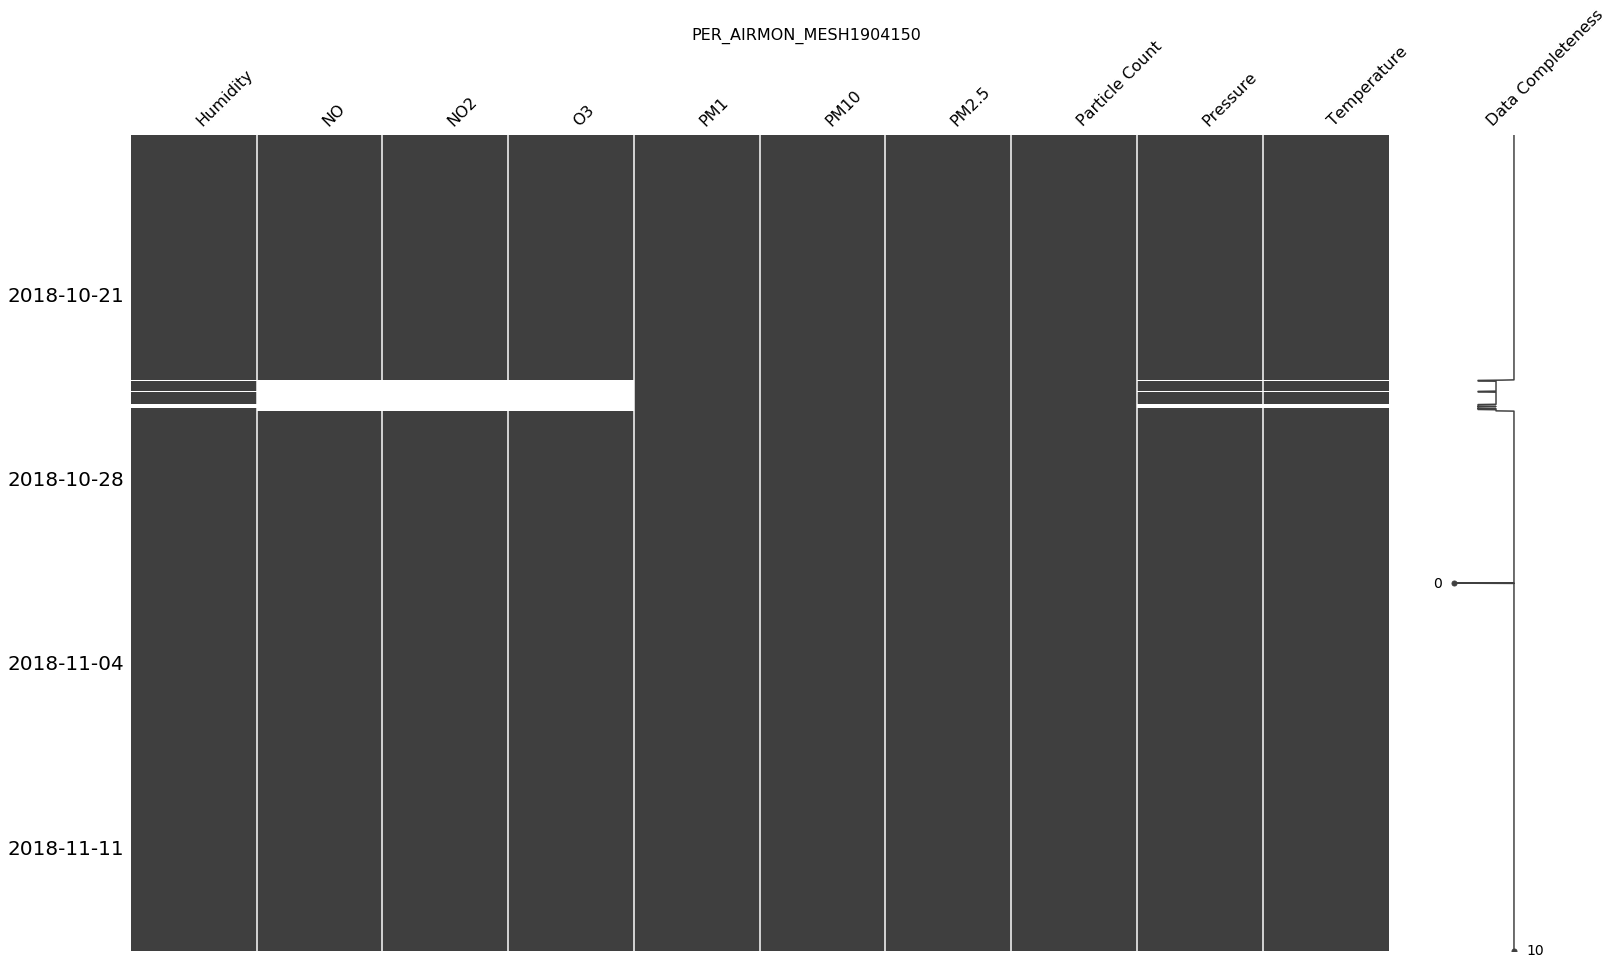

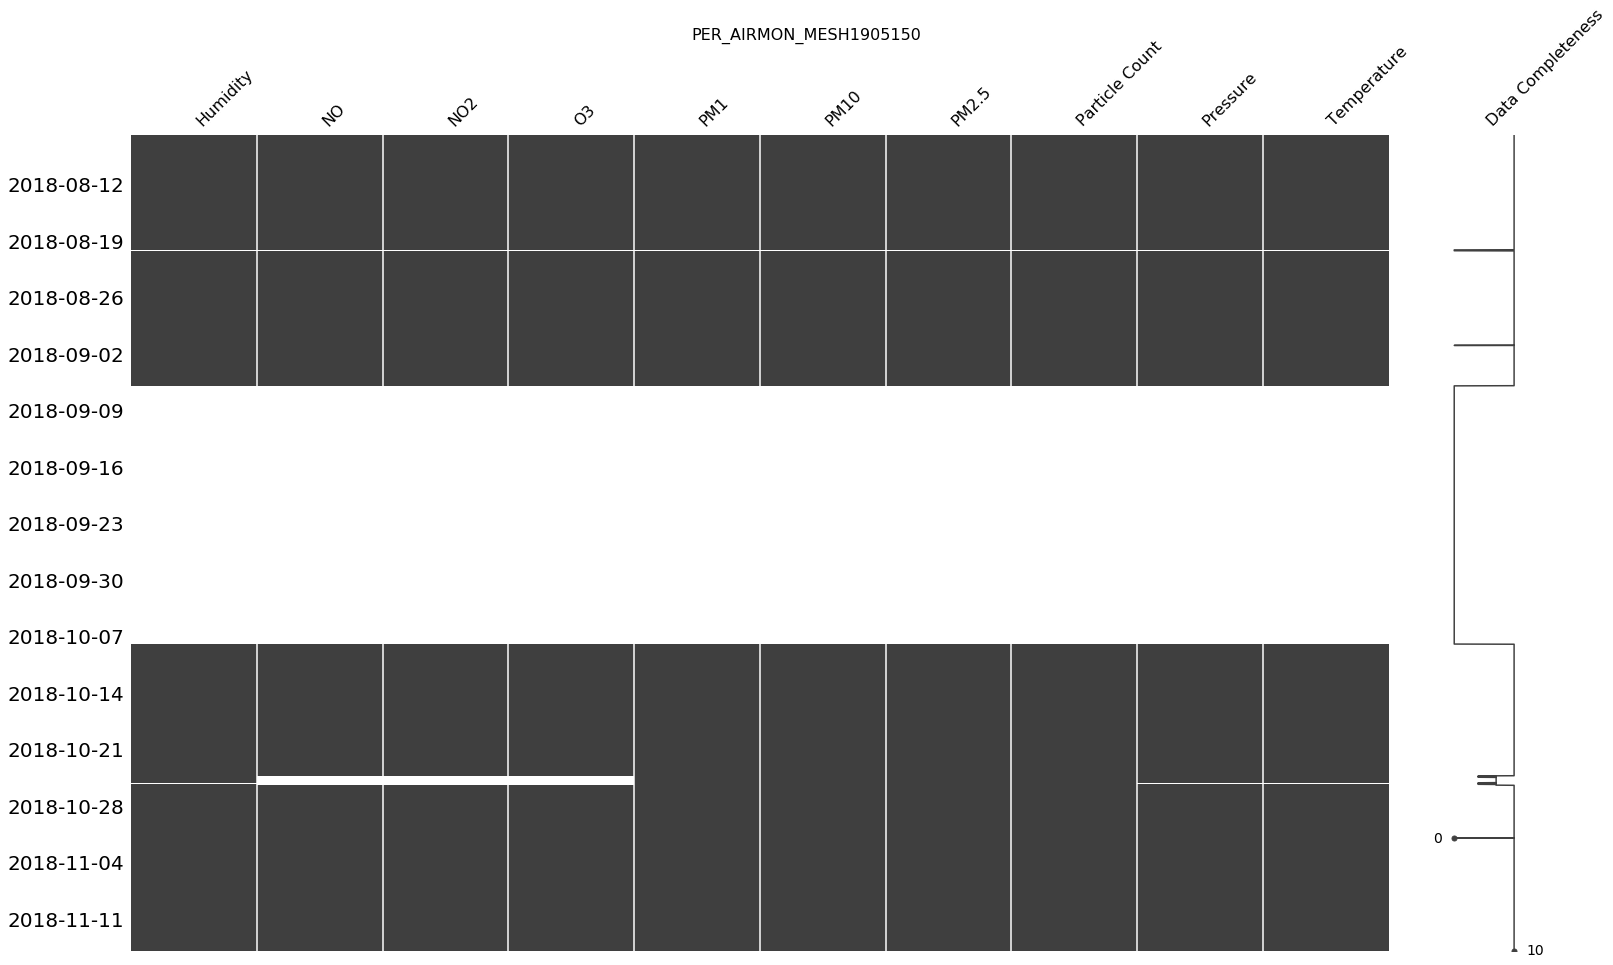

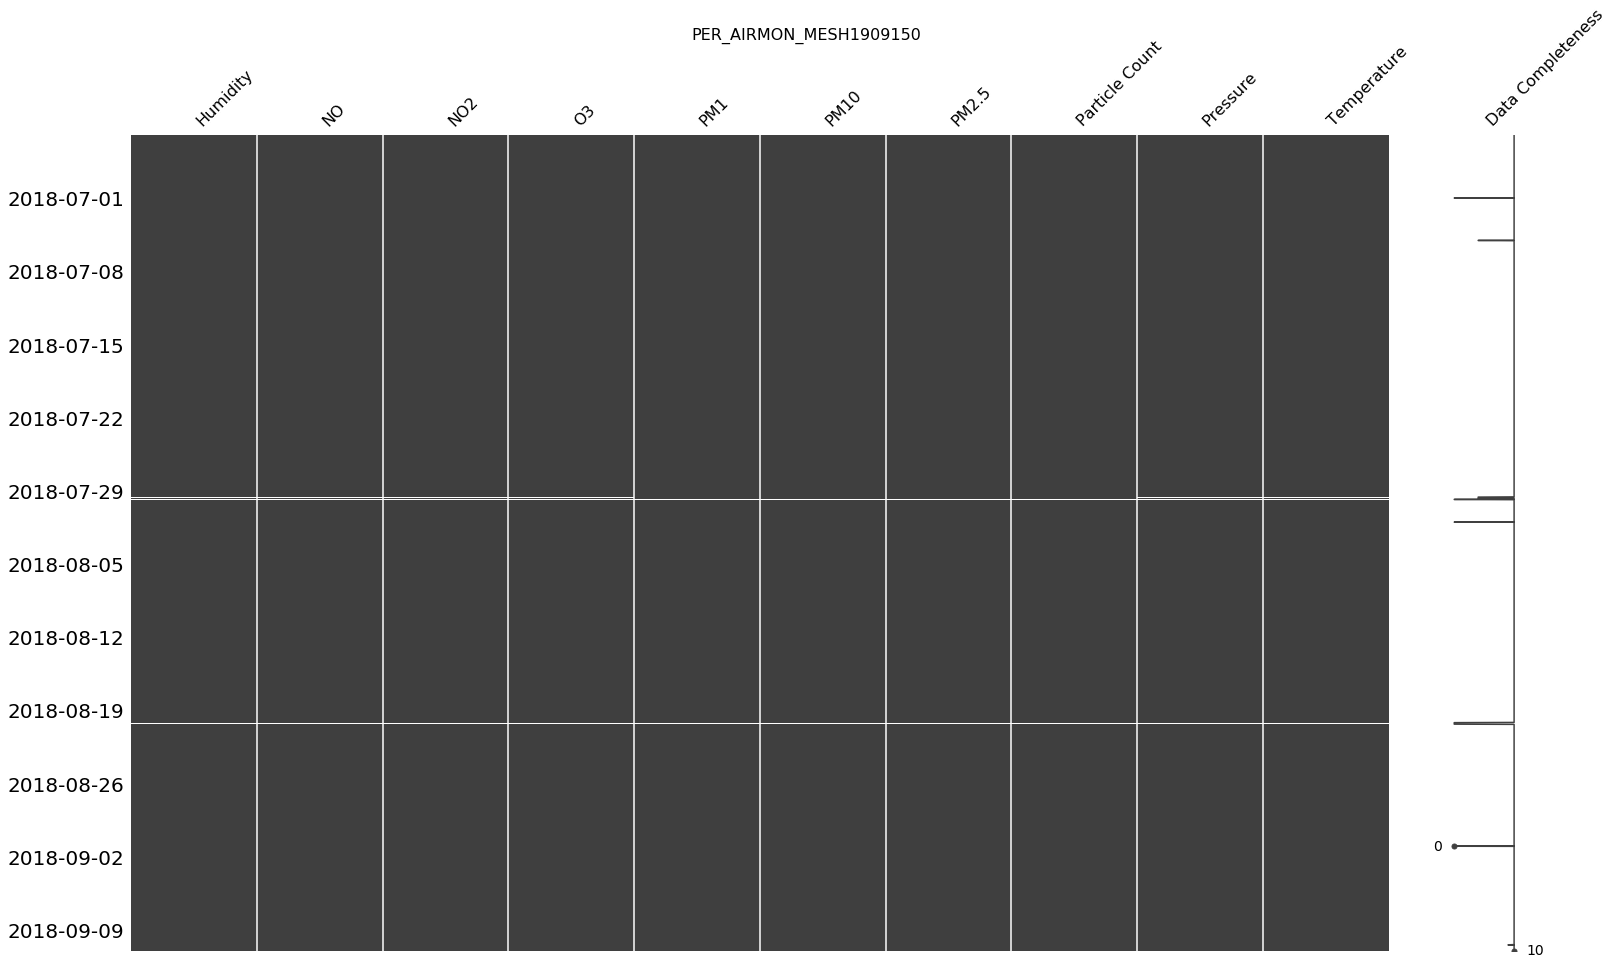

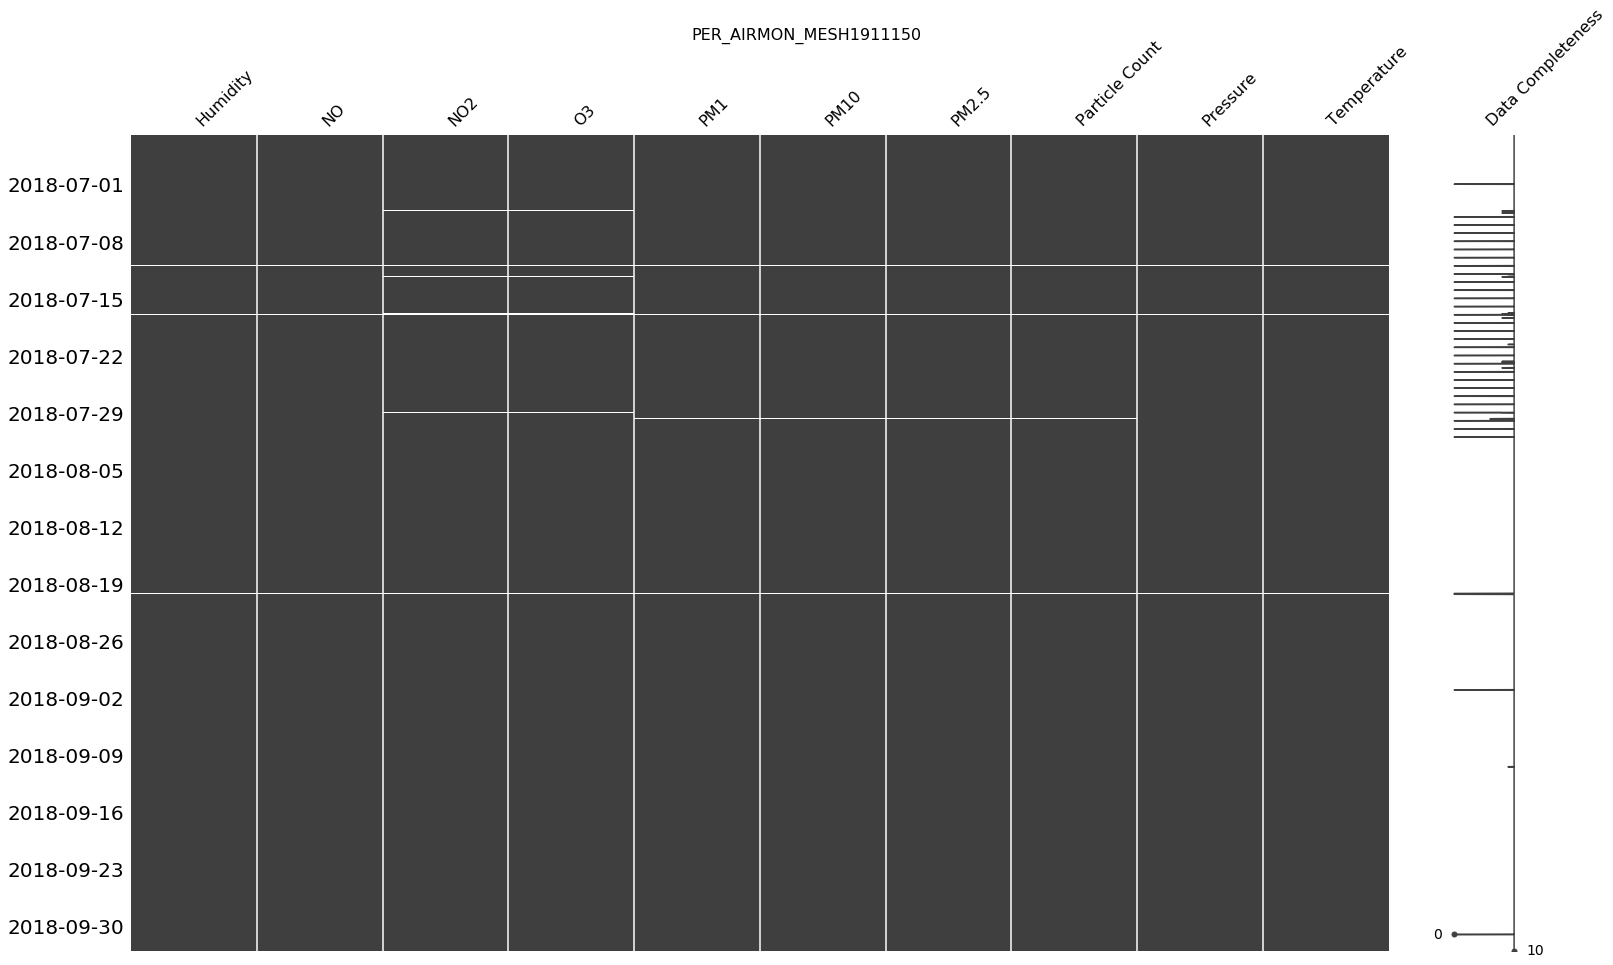

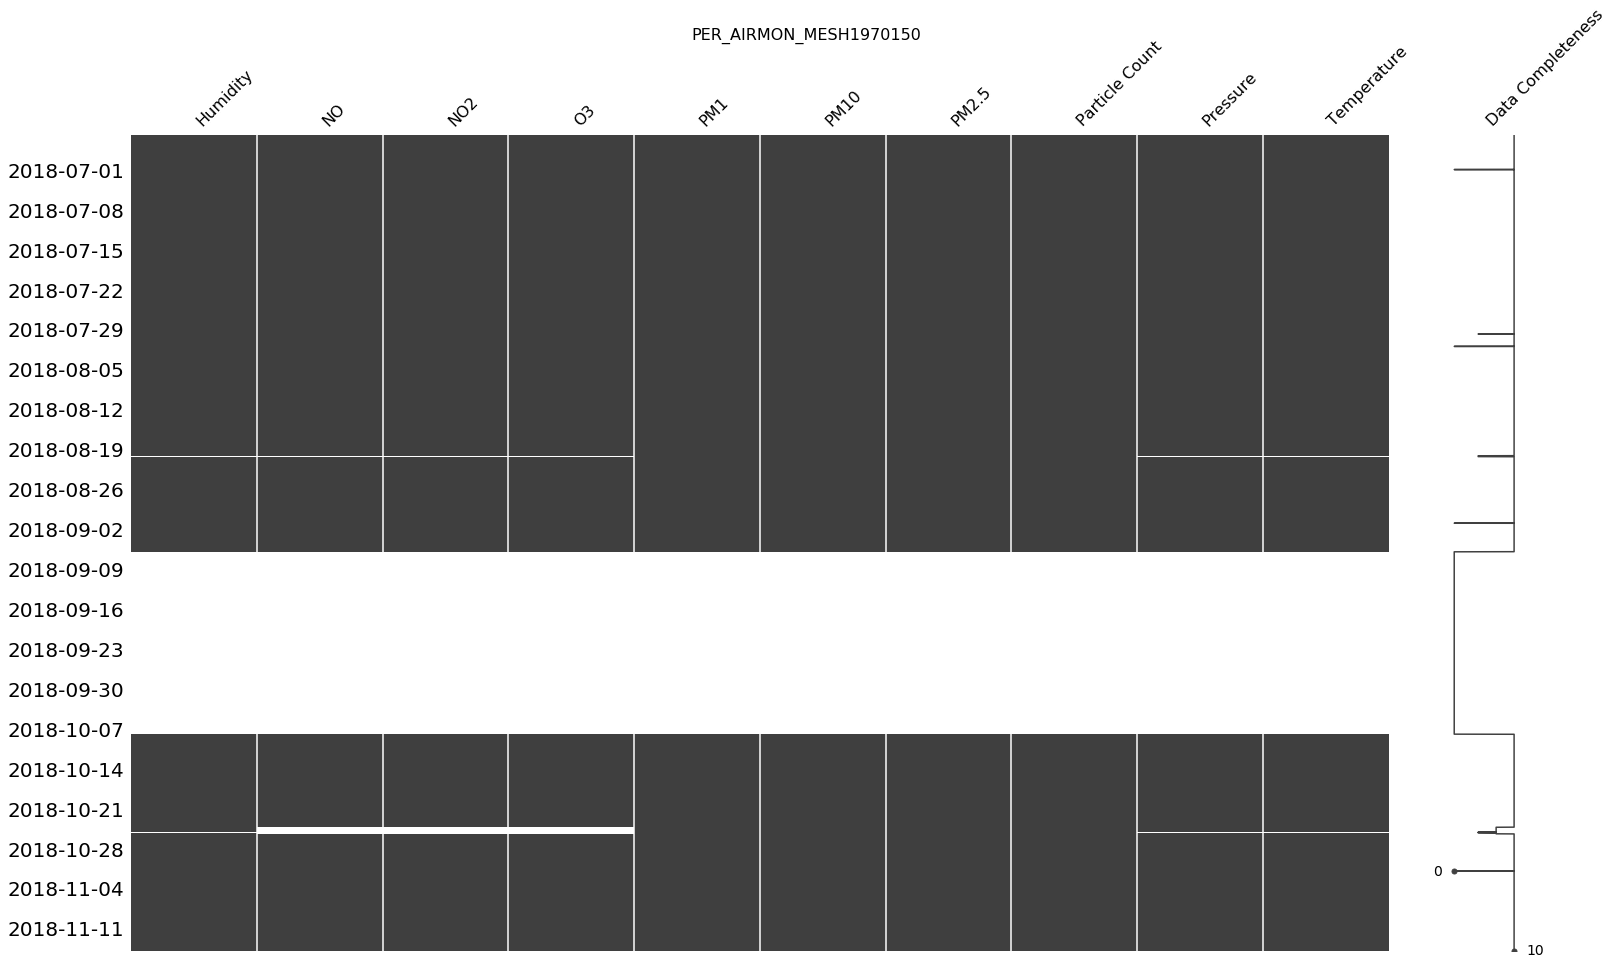

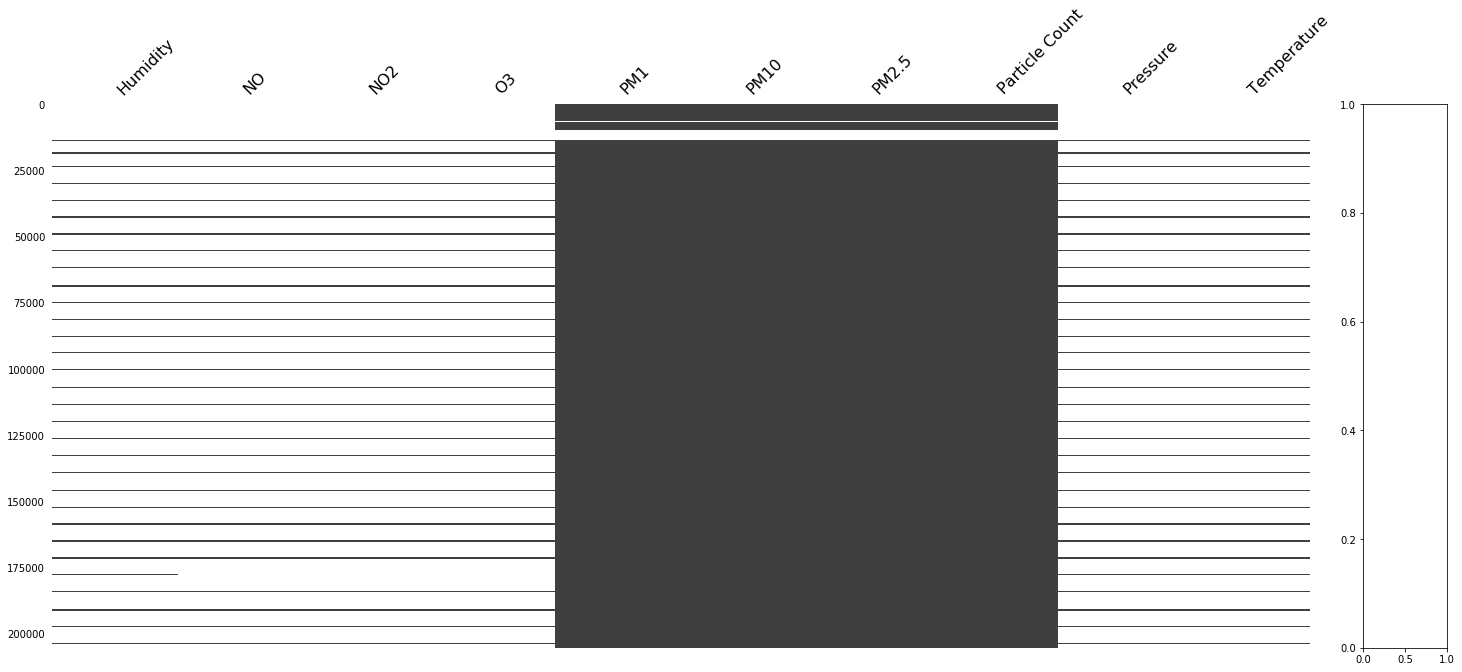

In [11]:
#Data quality assessment
data = pd.pivot_table(cleandata, values = 'Value', index=['Sensor Name','Timestamp'], columns = 'Variable').reset_index()

#min max of all sensors
minmax = data.groupby('Sensor Name')['Timestamp'].agg(['min','max']).reset_index()

def dateplot(x, y, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)

datagaps = pd.DataFrame()
datagaps['Sensor Name'] = data['Sensor Name'].unique()

#finding gaps in data
for index, row in minmax.iterrows():
    sensor_set = data.loc[data['Sensor Name'] == row['Sensor Name']]
    sensor_set = sensor_set.drop(columns=['Sensor Name'])
    # TODO: hard coded frequency, should be actually the sampling freq (now set all to 1min from 16 November 2018 - http://uoweb3.ncl.ac.uk/tools/note/8164195/) 
    idx_ref = pd.DatetimeIndex(start=row['min'], end=row['max'],freq='15min')                     
    gaps = idx_ref[~idx_ref.isin(sensor_set)]
    datagaps.loc[datagaps.index[datagaps['Sensor Name'] == row['Sensor Name']], 'Number of Missing Datapoints'] = int(len(gaps))
    dates = pd.DataFrame()
    dates['Timestamp'] = pd.date_range(start=row['min'], end=row['max'], freq='15min')
    missing_data = dates.merge(sensor_set, how='outer')
    missing_data = missing_data.set_index('Timestamp')
    #sensor_set.set_index('Timestamp')
    #sensor_set.plot(x = 'Timestamp', y='Value')
    #g = sns.FacetGrid(sensor_set, col='Variable', col_wrap=2)
    #g = g.map_dataframe(dateplot, 'Timestamp', 'Value')
    #print(missing_data.head())
    #print(row['min'], row['max'])
    try:
        ax = msno.matrix(missing_data,labels='Timestamp',freq='W')
        fig = ax.get_figure()
        fig.suptitle(row['Sensor Name'], fontsize=16)
        fig.set_size_inches(25,15)
        #fig.savefig(row['Sensor Name']+".png",bbox_inches='tight')
        fig.savefig(folder+row['Sensor Name']+'-missing_data.png')
    except Exception as e:
        print("Error processing " + row['Sensor Name'])
        print(e)
    
datagaps.to_csv(folder+'missing_data.csv', encoding='utf-8',header=True,index=False)
    

### Cleanup

In [13]:
# remove suspect readings (also consider some additional outliers)
data = cleandata.copy()
#data = pd.pivot_table(rawdata, values = 'Value', index=['Sensor Name','Timestamp'], columns = 'Variable').reset_index()
#data = data.loc[data['NO2'] > 200]
cdata = data.drop(data[data['Flagged as Suspect Reading'] == True].index)
cdata.head()

,Timestamp,Sensor Name,Variable,Units,Value,Flagged as Suspect Reading
0,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,Particle Count,Kgm -3,5.855000,False
1,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,PM1,ugm -3,0.791400,False
2,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,PM10,ugm -3,5.314220,False
3,2018-06-25 00:01:00,PER_AIRMON_MESH1971150,PM2.5,ugm -3,1.390732,False
4,2018-06-25 00:02:00,PER_AIRMON_MESH1971150,Particle Count,Kgm -3,2.751000,False


## Compute Quick Stats

### Overall Means

In [25]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}

#overall means
data = cdata.copy()
data = data[['Sensor Name','Timestamp','Variable','Value','Units']]
minmax = data.groupby('Sensor Name')['Timestamp'].agg(['min','max']).reset_index()
g1 = data.groupby( ['Sensor Name', 'Variable','Units'] ).agg(['mean', 'count','max','min']).reset_index()

for index, row in minmax.iterrows():
    days = (row['max'] - row['min']).days
    g1.loc[g1.index[g1['Sensor Name'] == row['Sensor Name']], 'Timeframe'] = row['min'].strftime('%d/%m/%Y %H:%M:%S') +" - "+row['max'].strftime('%d/%m/%Y %H:%M:%S')
    # should use 60 second as Epoch because http://uoweb3.ncl.ac.uk/tools/note/8164195/
    # however different sensors have different sampling frequency
    epoch = sensordata.loc[sensordata.index[sensordata['Sensor Name'] == row['Sensor Name']]]['Epoch'].astype(int)
    g1.loc[g1.index[g1['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = (days*86400)/900
g1['DataCompleteness'] = (g1['Value']['count']*100)/g1['MaxReadings']
g1.to_csv(folder+'overall_means.csv', encoding='utf-8',header=True,index=False)
g1

Sensor Name        Variable    Units        Value          \
                                                            mean   count   
0   PER_AIRMON_MESH1904150        Humidity        %    82.669820    2949   
1   PER_AIRMON_MESH1904150              NO   ugm -3    15.034046    2139   
2   PER_AIRMON_MESH1904150             NO2   ugm -3    28.599615    2859   
3   PER_AIRMON_MESH1904150              O3      ppb    19.301954    2859   
4   PER_AIRMON_MESH1904150             PM1   ugm -3     1.947996    2972   
5   PER_AIRMON_MESH1904150            PM10   ugm -3     8.080008    2972   
6   PER_AIRMON_MESH1904150           PM2.5   ugm -3     3.408584    2972   
7   PER_AIRMON_MESH1904150  Particle Count   Kgm -3     1.733809    2972   
8   PER_AIRMON_MESH1904150        Pressure      hpa  1009.081689    2949   
9   PER_AIRMON_MESH1904150     Temperature  Celsius     9.084164    2949   
10  PER_AIRMON_MESH1905150        Humidity        %    84.728246    6578   
11  PER_AIRMON_MESH1905150              NO   ugm -3    14.036794    4435   
12  PER_AIRMON_MESH1905150             NO2   ugm -3    21.244237    6496   
13  PER_AIRMON_MESH1905150              O3      ppb    22.761013    6496   
14  PER_AIRMON_MESH1905150             PM1   ugm -3     4.930556    6608   
15  PER_AIRMON_MESH1905150            PM10   ugm -3     8.832994    6608   
16  PER_AIRMON_MESH1905150           PM2.5   ugm -3     6.764469    6608   
17  PER_AIRMON_MESH1905150  Particle Count   Kgm -3     5.160351    6608   
18  PER_AIRMON_MESH1905150        Pressure      hpa  1016.752371    6578   
19  PER_AIRMON_MESH1905150     Temperature  Celsius    12.840407    6578   
20  PER_AIRMON_MESH1909150        Humidity        %    76.630417    7453   
21  PER_AIRMON_MESH1909150              NO   ugm -3    10.207461    7449   
22  PER_AIRMON_MESH1909150             NO2   ugm -3    32.794011    7453   
23  PER_AIRMON_MESH1909150              O3      ppb    18.603322    7453   
24  PER_AIRMON_MESH1909150             PM1   ugm -3     0.965635    7466   
25  PER_AIRMON_MESH1909150            PM10   ugm -3     3.362952    7466   
26  PER_AIRMON_MESH1909150           PM2.5   ugm -3     1.890105    7466   
27  PER_AIRMON_MESH1909150  Particle Count   Kgm -3     3.915176    7466   
28  PER_AIRMON_MESH1909150        Pressure      hpa  1018.496981    7453   
29  PER_AIRMON_MESH1909150     Temperature  Celsius    17.145740    7453   
30  PER_AIRMON_MESH1911150        Humidity        %    73.494758    9557   
31  PER_AIRMON_MESH1911150              NO   ugm -3    50.917986    9206   
32  PER_AIRMON_MESH1911150             NO2   ugm -3    23.636286    9514   
33  PER_AIRMON_MESH1911150              O3      ppb    21.680817    9505   
34  PER_AIRMON_MESH1911150             PM1   ugm -3     0.709358    9550   
35  PER_AIRMON_MESH1911150            PM10   ugm -3     4.573246    9550   
36  PER_AIRMON_MESH1911150           PM2.5   ugm -3     1.751009    9550   
37  PER_AIRMON_MESH1911150  Particle Count   Kgm -3     7.191884    9550   
38  PER_AIRMON_MESH1911150        Pressure      hpa  1024.425813    9557   
39  PER_AIRMON_MESH1911150     Temperature  Celsius    16.215120    9557   
40  PER_AIRMON_MESH1970150        Humidity        %    81.386356   10620   
41  PER_AIRMON_MESH1970150              NO   ugm -3    21.006173    8479   
42  PER_AIRMON_MESH1970150             NO2   ugm -3    21.957316   10518   
43  PER_AIRMON_MESH1970150              O3      ppb    22.816231   10518   
44  PER_AIRMON_MESH1970150             PM1   ugm -3     2.737906   10649   
45  PER_AIRMON_MESH1970150            PM10   ugm -3     7.633914   10649   
46  PER_AIRMON_MESH1970150           PM2.5   ugm -3     4.569979   10649   
47  PER_AIRMON_MESH1970150  Particle Count   Kgm -3     5.793370   10649   
48  PER_AIRMON_MESH1970150        Pressure      hpa  1012.121771   10620   
49  PER_AIRMON_MESH1970150     Temperature  Celsius    15.209134   10620   
50  PER_AIRMON_MESH1971150        Humidity        %    77.96032

### Weekly means

Week starts with Monday date

In [27]:
#weekly means
data = cdata.copy()
data = data[['Sensor Name','Timestamp','Variable','Value','Units']]


g2 = data.groupby(['Sensor Name', 'Variable','Units']).resample('W-Mon', closed='left', label='left', on='Timestamp').apply(get_stats).reset_index().sort_values('Timestamp')
g2[['min', 'max','count','mean']] = g2['Value'].apply(pd.Series)
g2 = g2.drop(columns=['Value'])

for index, row in sensordata.iterrows():
    # should use 60 second as Epoch because http://uoweb3.ncl.ac.uk/tools/note/8164195/
    # however different sensors have different sampling frequency
    g2.loc[g2.index[g2['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = (7*86400)/900

g2['DataCompleteness'] = (g2['count']*100)/g2['MaxReadings']

g2.to_csv(folder+'weekly_means.csv', encoding='utf-8',header=True,index=False)
g2.head()

,Sensor Name,Variable,Units,Timestamp,min,max,count,mean,MaxReadings,DataCompleteness
348,PER_AIRMON_MESH1911150,NO2,ugm -3,2018-06-25,3.250708,77.227206,670.0,24.056104,672.0,99.702381
378,PER_AIRMON_MESH1911150,PM1,ugm -3,2018-06-25,0.431700,4.977400,670.0,1.360538,672.0,99.702381
363,PER_AIRMON_MESH1911150,O3,ppb,2018-06-25,-3.901383,60.864944,670.0,32.994979,672.0,99.702381
333,PER_AIRMON_MESH1911150,NO,ugm -3,2018-06-25,1.537375,54.956124,345.0,18.701729,672.0,51.339286
318,PER_AIRMON_MESH1911150,Humidity,%,2018-06-25,35.799999,86.099998,670.0,69.643433,672.0,99.702381


### Weekday (Mon - Friday) Means

In [29]:
#weekday means
data = cdata.copy()
data = data[['Sensor Name','Timestamp','Variable','Value','Units']]
data['weekday'] = data['Timestamp'].apply(lambda x: x.weekday())
g3 = data[data['weekday'] < 5 ]
g3 = g3.drop('weekday', 1)
g3 = g3.groupby(['Sensor Name', 'Variable']).resample('W-Mon', closed='left', label='left', on='Timestamp').apply(get_stats).reset_index().sort_values('Timestamp')
g3[['min', 'max','count','mean']] = g3['Value'].apply(pd.Series)
g3 = g3.drop(columns=['Value'])

for index, row in sensordata.iterrows():
    g3.loc[g3.index[g3['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = (5*86400)/900

g3['DataCompleteness'] = (g3['count']*100)/g3['MaxReadings']

g3.to_csv(folder+'weekday_means.csv', encoding='utf-8',header=True,index=False)
g3.head()

,Sensor Name,Variable,Timestamp,min,max,count,mean,MaxReadings,DataCompleteness
348,PER_AIRMON_MESH1911150,NO2,2018-06-25,3.250708,77.227206,479.0,26.697379,480.0,99.791667
378,PER_AIRMON_MESH1911150,PM1,2018-06-25,0.471400,4.977400,479.0,1.598507,480.0,99.791667
363,PER_AIRMON_MESH1911150,O3,2018-06-25,-3.901383,56.311643,479.0,29.884232,480.0,99.791667
333,PER_AIRMON_MESH1911150,NO,2018-06-25,1.537375,54.956124,154.0,20.971803,480.0,32.083333
318,PER_AIRMON_MESH1911150,Humidity,2018-06-25,35.799999,86.099998,479.0,68.398121,480.0,99.791667


### Weekend (Sat - Sun) Means

In [30]:
#weekend means
data = cdata.copy()
data = data[['Sensor Name','Timestamp','Variable','Value','Units']]
data['weekday'] = data['Timestamp'].apply(lambda x: x.weekday())

g4 = data[data['weekday'] >= 5 ]
g4 = g4.drop('weekday', 1)


g4 = g4.groupby(["Sensor Name", "Variable"]).resample('W-Sat', closed='left', label='left', on='Timestamp').apply(get_stats).reset_index().sort_values('Timestamp')
g4[['min', 'max','count','mean']] = g4['Value'].apply(pd.Series)
g4 = g4.drop(columns=['Value'])

for index, row in sensordata.iterrows():
    # should use 60 second as Epoch because http://uoweb3.ncl.ac.uk/tools/note/8164195/
    # however different sensors have different sampling frequency
    g4.loc[g4.index[g4['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = (2*86400)/900

g4['DataCompleteness'] = (g4['count']*100)/g4['MaxReadings']


g4.to_csv(folder+'results/weekend_means.csv', encoding='utf-8',header=True,index=False)
g4.head()

,Sensor Name,Variable,Timestamp,min,max,count,mean,MaxReadings,DataCompleteness
316,PER_AIRMON_MESH1911150,NO2,2018-06-30,5.918804,55.459248,191.0,17.432171,192.0,99.479167
688,PER_AIRMON_MESH1971150,O3,2018-06-30,26.952208,65.141000,191.0,43.380828,192.0,99.479167
608,PER_AIRMON_MESH1970150,Temperature,2018-06-30,13.100000,23.100000,191.0,17.333508,192.0,99.479167
277,PER_AIRMON_MESH1909150,Temperature,2018-06-30,12.600000,23.299999,191.0,17.378534,192.0,99.479167
344,PER_AIRMON_MESH1911150,PM1,2018-06-30,0.431700,1.359900,191.0,0.763748,192.0,99.479167


### Hourly Means

In [33]:
data = cdata.copy()
g5 = data[['Sensor Name','Timestamp','Variable','Value','Units']]


g5 = g5.groupby(["Sensor Name", "Variable"]).resample('H', closed='left', label='left', on='Timestamp').apply(get_stats).reset_index().sort_values('Timestamp')
g5[['min', 'max','count','mean']] = g5['Value'].apply(pd.Series)
g5 = g5.drop(columns=['Value'])

for index, row in sensordata.iterrows():
    # should use 60 second as Epoch because http://uoweb3.ncl.ac.uk/tools/note/8164195/
    # however different sensors have different sampling frequency
    g5.loc[g5.index[g5['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = 3600/900

g5['DataCompleteness'] = (g5['count']*100)/g5['MaxReadings']

# AQ index for NO2
'''
Reading,Index,Band,BandLow,BandHigh
NO2,1,Low,0,67
NO2,2,Low,68,134
NO2,3,Low,135,200
NO2,4,Moderate,201,267
NO2,5,Moderate,268,334
NO2,6,Moderate,335,400
NO2,7,High,401,467
NO2,8,High,468,534
NO2,9,High,535,600
NO2,10,Very High,601
'''
# aq_index=pd.read_csv("aq_index.csv",sep=',',index_col=False, header=0)
#for index,row in aq_index.iterrows():
#    g5.loc[g5.index[(g5['mean'] >= row['BandLow']) & (g5['mean'] <= row['BandHigh'])], 'Index'] = row['Index']

g5.to_csv(folder+'hourly_means.csv', encoding='utf-8',header=True,index=False)
g5.head()

,Sensor Name,Variable,Timestamp,min,max,count,mean,MaxReadings,DataCompleteness
73951,PER_AIRMON_MESH1970150,Humidity,2018-06-25,58.900002,62.000000,3.0,60.433335,4.0,75.0
111583,PER_AIRMON_MESH1971150,NO,2018-06-25,16.384000,16.561375,3.0,16.493500,4.0,75.0
44401,PER_AIRMON_MESH1909150,Particle Count,2018-06-25,2.354400,5.559900,3.0,3.854600,4.0,75.0
87559,PER_AIRMON_MESH1970150,PM1,2018-06-25,0.695400,0.808200,3.0,0.738000,4.0,75.0
31290,PER_AIRMON_MESH1909150,Humidity,2018-06-25,58.700001,62.000000,3.0,60.333333,4.0,75.0


### Hourly Means for sensors for the whole period

In [35]:
data = cdata.copy()
g51 = data[['Sensor Name','Timestamp','Variable','Value','Units']]
g51['hourofday'] = g51['Timestamp'].apply(lambda x: x.hour)
g51 = g51.groupby( ['Sensor Name', 'Variable','hourofday'] ).agg(['mean','count','max','min']).reset_index()
g51[['mean', 'count','max','min']] = g51['Value'].apply(pd.Series)
g51 = g51.drop(columns=['Value'])

for index, row in minmax.iterrows():
    days = (row['max'] - row['min']).days
    g51.loc[g51.index[g51['Sensor Name'] == row['Sensor Name']], 'Timeframe'] = row['min'].strftime('%d/%m/%Y %H:%M:%S') +" - "+row['max'].strftime('%d/%m/%Y %H:%M:%S')
    epoch = sensordata.loc[sensordata.index[sensordata['Sensor Name'] == row['Sensor Name']]]['Epoch']
    # from 16 November 2018 all sensors are 1min freq http://uoweb3.ncl.ac.uk/tools/note/8164195/
    # so it should be 60 readings in an hour
    g51.loc[g51.index[g51['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = days*4
g51['DataCompleteness'] = (g51['count']*100)/g51['MaxReadings']
#g1.to_csv(folder+'results/overall_means.csv', encoding='utf-8',header=True,index=False)
g51.to_csv(folder+'overall_hourly_means.csv', encoding='utf-8',header=True,index=False)
g51

,Sensor Name,Variable,hourofday,mean,count,max,min,Timeframe,MaxReadings,DataCompleteness
,,,,,,,,,,
0,PER_AIRMON_MESH1904150,Humidity,0,84.219512,123,90.100000,67.80000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,102.500000
1,PER_AIRMON_MESH1904150,Humidity,1,84.450000,124,90.800000,72.30000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,103.333333
2,PER_AIRMON_MESH1904150,Humidity,2,85.008871,124,91.800000,74.00000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,103.333333
3,PER_AIRMON_MESH1904150,Humidity,3,85.583065,124,91.900000,75.40000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,103.333333
4,PER_AIRMON_MESH1904150,Humidity,4,85.975806,124,92.600000,75.60000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,103.333333
5,PER_AIRMON_MESH1904150,Humidity,5,86.335537,121,92.300000,77.50000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,100.833333
6,PER_AIRMON_MESH1904150,Humidity,6,86.339167,120,91.200000,77.50000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,100.000000
7,PER_AIRMON_MESH1904150,Humidity,7,86.167797,118,90.100000,77.60000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,98.333333
8,PER_AIRMON_MESH1904150,Humidity,8,85.720833,120,91.000000,77.50000,15/10/2018 00:00:00 - 14/11/2018 23:00:00,120.0,100.000000


### Hourly means over the period

/Users/aare/Code/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



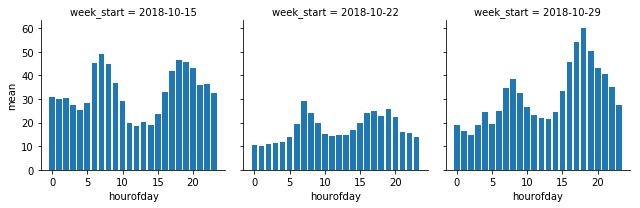

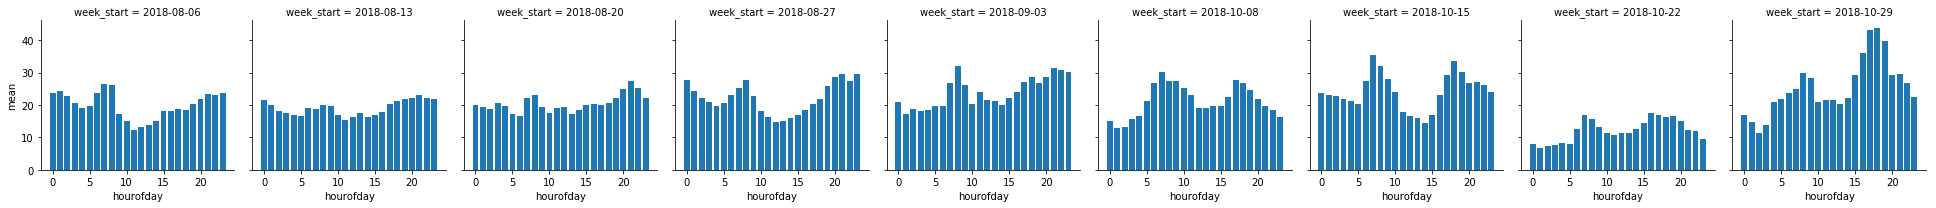

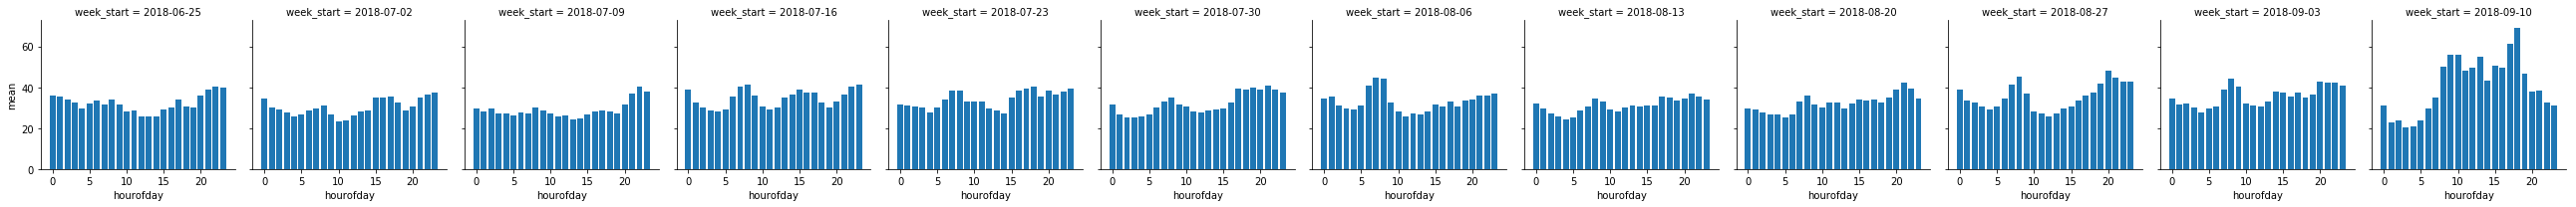

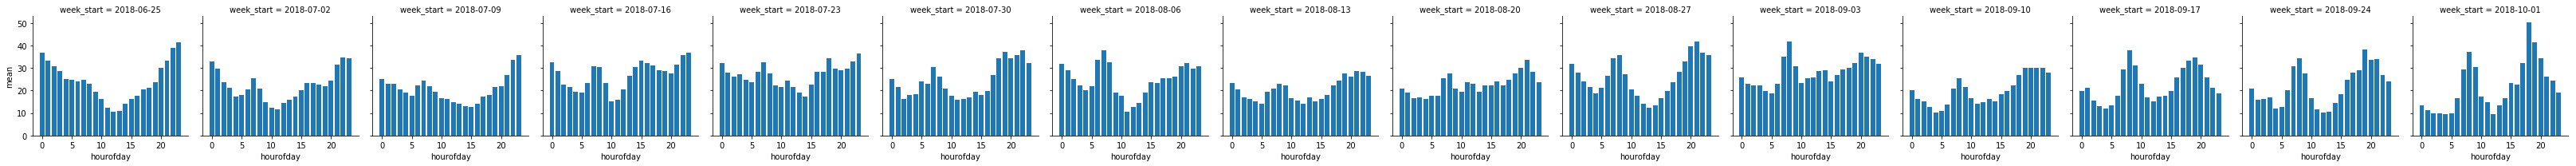

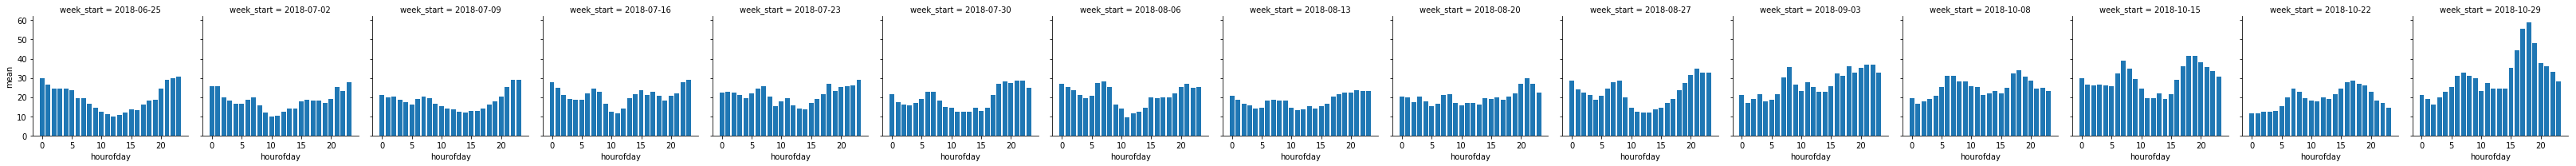

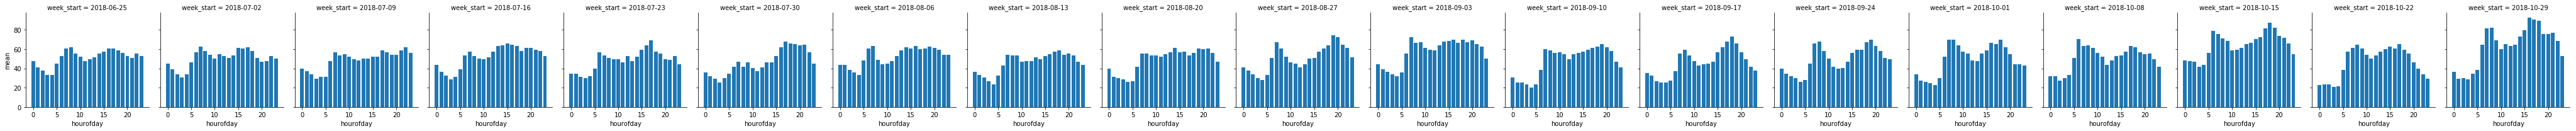

In [171]:
data = cdata.copy()
data = data[['Sensor Name','Timestamp','Variable','Value','Units']]
data['hourofday'] = data['Timestamp'].apply(lambda x: x.hour)

data['week_start'] = data['Timestamp'].dt.to_period('W').apply(lambda r: r.start_time)


g6 = data.groupby( ['Sensor Name', 'Variable','Units','hourofday','week_start'] ).agg(['mean','count','max','min']).reset_index()
g6[['mean', 'count','max','min']] = g6['Value'].apply(pd.Series)
g6 = g6.drop(columns=['Value'])

for index, row in sensordata.iterrows():
    g6.loc[g6.index[g6['Sensor Name'] == row['Sensor Name']], 'MaxReadings'] = (7*3600)/900

g6['DataCompleteness'] = (g6['count']*100)/g6['MaxReadings']
#g6.to_csv(folder+'results/hour_means_byweek.csv', encoding='utf-8',header=True,index=False)

#sns.catplot(x='hourofday', y='mean',col='week_start', data=g6,kind='bar',height=10, aspect=1);
#g = sns.FacetGrid(g6, col="week_start", y='mean', height=4, aspect=.5)
#g = g.map(plt.hist, "hoursofday", bins=bins)

grouped = g6.groupby('Sensor Name')

for name, group in grouped:
    #g = sns.catplot(x='hourofday', y='mean',col='week_start', data=group,kind='bar')
    group['week_start'] = group['week_start'].dt.strftime('%Y-%m-%d')
    g = sns.FacetGrid(group, col="week_start")
    g = g.map(plt.bar, "hourofday", "mean")
    g.fig.savefig(folder+name+"byweekly-hourly.png")


## Compile Report

In [105]:
import xlsxwriter
import glob
import csv
import os

workbook = xlsxwriter.Workbook(folder+'results/compiled.xlsx') 
for filename in glob.glob(folder+"results/*.csv"):
    (f_path, f_name) = os.path.split(filename)
    (f_short_name, f_extension) = os.path.splitext(f_name)
    ws = workbook.add_worksheet(f_short_name)
    spamReader = csv.reader(open(filename, 'rt'), delimiter=',',quotechar='"')
    row_count = 0
    print(f_short_name)
    for row in spamReader:
        for col in range(len(row)):
            ws.write(row_count,col,row[col])
        row_count +=1

workbook.close()

weekday_means
weekend_means
min_max
missing_data
overall_means
hour_means_byweek
sensors
weekly_means
hourly_means
